<a href="https://colab.research.google.com/github/csendranshi/MLworkshopSFIT/blob/master/LSTM_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anshika Gupta 

### Import Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
deu_path='/content/drive/My Drive/Colab Notebooks/LSTM_Transformers/deu.txt'
model_path='/content/drive/My Drive/Colab Notebooks/LSTM_Transformers/model.h1.10_jul_20_2'

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [ ]:
# function to read raw text file
def read_text(filename):
    #complete the function
    file =open(filename,mode='rt',encoding='utf-8')
    text=file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [ ]:
# split a text into sentences
def to_lines(text):
    #complete the function
    sents= text.strip().split('\n')
    sents=[i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [ ]:
data = read_text(deu_path)
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [ ]:
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [ ]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['Tom lost seventy pounds.', 'Tom hat 30\xa0kg abgenommen.'],
       ['Tom loves fried chicken.', 'Tom isst sehr gerne Brathähnchen.'],
       ['Tom loves fried chicken.', 'Tom isst sehr gerne Brathendl.']],
      dtype='<U302')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [ ]:
deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['Tom lost seventy pounds', 'Tom hat 30\xa0kg abgenommen'],
       ['Tom loves fried chicken', 'Tom isst sehr gerne Brathähnchen'],
       ['Tom loves fried chicken', 'Tom isst sehr gerne Brathendl']],
      dtype='<U302')

In [ ]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [ ]:
deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['tom lost seventy pounds', 'tom hat 30\xa0kg abgenommen'],
       ['tom loves fried chicken', 'tom isst sehr gerne brathähnchen'],
       ['tom loves fried chicken', 'tom isst sehr gerne brathendl']],
      dtype='<U302')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

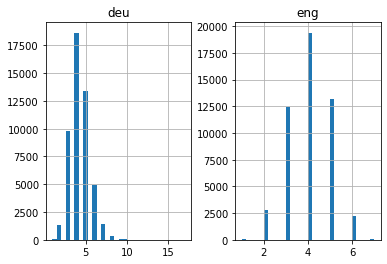

In [ ]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    #complete the function
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6509


In [ ]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 11078


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    #complete the function
    seq=tokenizer.texts_to_sequences(lines)
    seq=pad_sequences(seq,maxlen=length,padding='post')

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)



*   List item
*   List item



It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [ ]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [ ]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    #complete the function
    model=Sequential()
    model.add(Embedding(in_vocab,units,input_length=in_timesteps,mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units,return_sequences=True))
    model.add(Dense(out_vocab,activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [ ]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [ ]:
filename = model_path
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=5, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 18s 568us/step - loss: 3.6513 - val_loss: 3.0659

Epoch 00001: val_loss improved from inf to 3.06592, saving model to /content/drive/My Drive/Colab Notebooks/LSTM_Transformers/model.h1.10_jul_20_2
Epoch 2/5
32000/32000 [==============================] - 15s 477us/step - loss: 3.0046 - val_loss: 2.9351

Epoch 00002: val_loss improved from 3.06592 to 2.93510, saving model to /content/drive/My Drive/Colab Notebooks/LSTM_Transformers/model.h1.10_jul_20_2
Epoch 3/5
32000/32000 [==============================] - 15s 478us/step - loss: 2.8118 - val_loss: 2.7592

Epoch 00003: val_loss improved from 2.93510 to 2.75921, saving model to /content/drive/My Drive/Colab Notebooks/LSTM_Transformers/model.h1.10_jul_20_2
Epoch 4/5
32000/32000 [==============================] - 15s 478us/step - loss: 2.6328 - val_loss: 2.6684

Epoch 00004: val_loss improved from 2.75921 to 2.66839, saving model to /c

Let's compare the training loss and the validation loss.

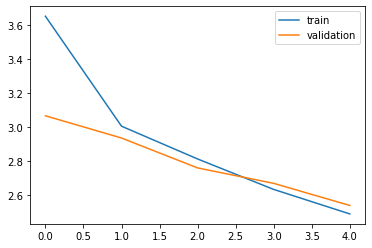

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [ ]:
model = load_model(model_path)
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
def get_word(n, tokenizer):
    #complete the function
    for word,index in tokenizer.word_index.items():
      if index== n:
        return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
0,dinners almost ready,its is very
1,no kidding,youre
2,wheres my cup,this is a
3,tom is precise,tom is a
4,tom is deaf in one ear,tom is a
5,i asked her for a date,i cant tom
6,can i drive the tractor,can i you
7,is his father a doctor,its is a
8,the food is ready,its is
9,please polish my shoes,lets me the


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,where did tom work,she tom
9986,call an ambulance,the
9987,tom is making faces,tom is
9988,please wait a moment,the your the
9989,once is not enough,it tom
9990,he bought a new car,he is a
9991,im drinking milk,i love
9992,talk slower,youre
9993,if you wish ill ask,do i you
9994,its hit or miss,its is a


In [ ]:
pred_df.sample(15)

,actual,predicted
9957,i often read books,i dont to
3322,hey look at the snow,what me
1317,you remind me of tom,do you
5031,im perfectly normal,im am a
1448,this is alis book,the is a
3889,can you help me,do you want to
117,tom waited anxiously,tom is
950,tom is different,tom is a
8923,she has two daughters,she is a
8582,your secrets safe,the is
